# Text Summarization in Natural Language Processing

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vuhung16au/nlp-learning-journey/blob/main/examples/text-summarization.ipynb)

## Overview

Text summarization is the process of creating a concise and coherent summary of a longer text while preserving key information and main ideas. It can be extractive (selecting important sentences) or abstractive (generating new text).

## What You'll Learn

- Extractive vs abstractive summarization
- Frequency-based approaches
- TF-IDF based summarization
- TextRank algorithm
- Transformer-based summarization
- Evaluation metrics
- Real-world applications

## Prerequisites

Basic understanding of Python, NLP preprocessing, and vector representations.

In [1]:
# Environment Detection and Setup
import sys
import subprocess

# Detect the runtime environment
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules
IS_LOCAL = not (IS_COLAB or IS_KAGGLE)

print(f"Environment detected:")
print(f"  - Local: {IS_LOCAL}")
print(f"  - Google Colab: {IS_COLAB}")
print(f"  - Kaggle: {IS_KAGGLE}")

# Platform-specific system setup
if IS_COLAB:
    print("\nSetting up Google Colab environment...")
    !apt update -qq
    !apt install -y -qq libpq-dev
elif IS_KAGGLE:
    print("\nSetting up Kaggle environment...")
    # Kaggle usually has most packages pre-installed
else:
    print("\nSetting up local environment...")

# Install required packages for this notebook
required_packages = [
    "nltk",
    "scikit-learn",
    "transformers",
    "torch",
    "pandas",
    "matplotlib",
    "seaborn",
    "networkx",
    "rouge-score"
]

print("\nInstalling required packages...")
for package in required_packages:
    if IS_COLAB or IS_KAGGLE:
        !pip install -q {package}
    else:
        subprocess.run([sys.executable, "-m", "pip", "install", "-q", package],
                      capture_output=True)
    print(f"✓ {package}")

print("\n🎉 Environment setup complete!")

Environment detected:
  - Local: False
  - Google Colab: True
  - Kaggle: False

Setting up Google Colab environment...
38 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
libpq-dev is already the newest version (14.19-0ubuntu0.22.04.1).
libpq-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.

Installing required packages...
✓ nltk
✓ scikit-learn
✓ transformers
✓ torch
✓ pandas
✓ matplotlib
✓ seaborn
✓ networkx
  Preparing metadata (setup.py) ... done
✓ rouge-score

🎉 Environment setup complete!


In [2]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import Counter, defaultdict
import re
import heapq

# NLP libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Download NLTK data with error handling
nltk_datasets = ['punkt', 'punkt_tab', 'stopwords', 'wordnet']
print("Downloading NLTK datasets...")
for dataset in nltk_datasets:
    try:
        nltk.download(dataset, quiet=True)
        print(f"✓ {dataset}")
    except Exception as e:
        print(f"⚠️  Failed to download {dataset}: {e}")

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize components with error handling
try:
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    print("✓ NLTK components initialized")
except Exception as e:
    print(f"⚠️  NLTK components initialization failed: {e}")
    stop_words = set()
    lemmatizer = None

plt.style.use('default')
sns.set_palette("husl")

# Note: Transformers models will be loaded when needed due to potential network requirements
print("\n⚠️  Note: Transformer models require internet access and will be loaded when needed.")

✓ punkt
✓ punkt_tab
✓ stopwords
✓ wordnet
✓ NLTK components initialized

⚠️  Note: Transformer models require internet access and will be loaded when needed.


## Sample Text for Summarization

In [3]:
# Sample articles for summarization
sample_articles = {
    "Technology": """
    Artificial Intelligence has revolutionized numerous industries in recent years. Machine learning algorithms
    are now capable of performing tasks that were once thought to be exclusively human. Deep learning models
    have shown remarkable success in image recognition, natural language processing, and game playing.

    The healthcare industry has particularly benefited from AI advancements. Medical imaging systems powered
    by AI can detect diseases earlier and more accurately than traditional methods. Drug discovery processes
    have been accelerated through machine learning techniques that can predict molecular behavior.

    However, the rapid advancement of AI also raises concerns about job displacement and ethical implications.
    Many experts argue for the need to develop responsible AI systems that are transparent and fair.
    Governments worldwide are working on regulations to ensure AI development serves humanity's best interests.

    The future of AI looks promising with continued research in areas like quantum computing and neural networks.
    As AI systems become more sophisticated, they will likely play an even greater role in solving complex
    global challenges such as climate change and resource management.
    """,

    "Climate": """
    Climate change represents one of the most pressing challenges of our time. Rising global temperatures
    are causing widespread environmental disruptions including melting ice caps, rising sea levels, and
    extreme weather events. The primary driver of this change is the emission of greenhouse gases from human activities.

    Renewable energy sources such as solar and wind power have emerged as crucial solutions. These technologies
    have become more efficient and cost-effective, making them viable alternatives to fossil fuels. Many countries
    have committed to achieving net-zero emissions by 2050 through massive investments in clean energy infrastructure.

    Individual actions also play a significant role in combating climate change. Reducing energy consumption,
    choosing sustainable transportation options, and supporting environmentally conscious businesses can
    collectively make a substantial impact. Education and awareness campaigns are essential for motivating
    widespread behavioral changes.

    International cooperation is vital for addressing this global challenge. The Paris Agreement has brought
    nations together to set emission reduction targets and share climate technologies. However, achieving
    these goals requires sustained political will and continued innovation in clean technologies.
    """
}

print("Sample Articles for Summarization:")
for title, article in sample_articles.items():
    word_count = len(article.split())
    sentence_count = len(sent_tokenize(article))
    print(f"\n{title} Article:")
    print(f"  Words: {word_count}, Sentences: {sentence_count}")
    print(f"  Preview: {article.strip()[:200]}...")

Sample Articles for Summarization:

Technology Article:
  Words: 170, Sentences: 11
  Preview: Artificial Intelligence has revolutionized numerous industries in recent years. Machine learning algorithms 
    are now capable of performing tasks that were once thought to be exclusively human. Dee...

Climate Article:
  Words: 171, Sentences: 12
  Preview: Climate change represents one of the most pressing challenges of our time. Rising global temperatures 
    are causing widespread environmental disruptions including melting ice caps, rising sea level...


## Frequency-Based Summarization

Simple approach based on word frequency and sentence scoring.

In [4]:
def preprocess_text(text):
    """Basic text preprocessing"""
    # Remove extra whitespace and split into sentences
    sentences = sent_tokenize(text.strip())
    return sentences

def frequency_based_summarization(text, num_sentences=3):
    """Summarize text based on word frequency"""
    # Preprocess
    sentences = preprocess_text(text)

    # Tokenize and count word frequencies
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalnum() and word not in stop_words]

    word_freq = Counter(words)

    # Score sentences based on word frequencies
    sentence_scores = {}
    for i, sentence in enumerate(sentences):
        sentence_words = word_tokenize(sentence.lower())
        sentence_words = [word for word in sentence_words if word.isalnum() and word not in stop_words]

        score = 0
        for word in sentence_words:
            score += word_freq.get(word, 0)

        # Normalize by sentence length
        if len(sentence_words) > 0:
            sentence_scores[i] = score / len(sentence_words)
        else:
            sentence_scores[i] = 0

    # Select top sentences
    top_sentences = heapq.nlargest(num_sentences, sentence_scores, key=sentence_scores.get)
    top_sentences.sort()  # Maintain original order

    summary = ' '.join([sentences[i] for i in top_sentences])

    return {
        'summary': summary,
        'selected_sentences': top_sentences,
        'sentence_scores': sentence_scores,
        'word_frequencies': word_freq.most_common(10)
    }

# Test frequency-based summarization
print("Frequency-Based Summarization:")
print("=" * 50)

for title, article in sample_articles.items():
    result = frequency_based_summarization(article, num_sentences=2)

    print(f"\n{title} Article Summary:")
    print(f"Summary: {result['summary']}")
    print(f"Top words: {[word for word, freq in result['word_frequencies'][:5]]}")
    print("-" * 30)

Frequency-Based Summarization:

Technology Article Summary:
Summary: The healthcare industry has particularly benefited from AI advancements. Many experts argue for the need to develop responsible AI systems that are transparent and fair.
Top words: ['ai', 'learning', 'systems', 'machine', 'artificial']
------------------------------

Climate Article Summary:
Summary: Climate change represents one of the most pressing challenges of our time. Individual actions also play a significant role in combating climate change.
Top words: ['climate', 'change', 'energy', 'technologies', 'rising']
------------------------------


## TF-IDF Based Summarization

Using TF-IDF scores to identify important sentences.

In [5]:
def tfidf_based_summarization(text, num_sentences=3):
    """Summarize text using TF-IDF scores"""
    sentences = preprocess_text(text)

    if len(sentences) <= num_sentences:
        return {
            'summary': text.strip(),
            'selected_sentences': list(range(len(sentences))),
            'tfidf_scores': []
        }

    # Create TF-IDF matrix
    vectorizer = TfidfVectorizer(
        stop_words='english',
        lowercase=True,
        max_features=1000
    )

    tfidf_matrix = vectorizer.fit_transform(sentences)

    # Calculate sentence scores (sum of TF-IDF values)
    sentence_scores = np.array(tfidf_matrix.sum(axis=1)).flatten()

    # Select top sentences
    top_indices = sentence_scores.argsort()[-num_sentences:][::-1]
    top_indices.sort()  # Maintain original order

    summary = ' '.join([sentences[i] for i in top_indices])

    return {
        'summary': summary,
        'selected_sentences': top_indices.tolist(),
        'tfidf_scores': sentence_scores.tolist(),
        'feature_names': vectorizer.get_feature_names_out()[:10].tolist()
    }

# Test TF-IDF summarization
print("TF-IDF Based Summarization:")
print("=" * 50)

for title, article in sample_articles.items():
    result = tfidf_based_summarization(article, num_sentences=2)

    print(f"\n{title} Article Summary:")
    print(f"Summary: {result['summary']}")
    print(f"Selected sentences: {result['selected_sentences']}")
    print("-" * 30)

TF-IDF Based Summarization:

Technology Article Summary:
Summary: Deep learning models 
    have shown remarkable success in image recognition, natural language processing, and game playing. As AI systems become more sophisticated, they will likely play an even greater role in solving complex 
    global challenges such as climate change and resource management.
Selected sentences: [2, 10]
------------------------------

Climate Article Summary:
Summary: Rising global temperatures 
    are causing widespread environmental disruptions including melting ice caps, rising sea levels, and 
    extreme weather events. Reducing energy consumption, 
    choosing sustainable transportation options, and supporting environmentally conscious businesses can 
    collectively make a substantial impact.
Selected sentences: [1, 7]
------------------------------


## TextRank Algorithm

Graph-based ranking algorithm similar to PageRank for sentence selection.

In [6]:
def textrank_summarization(text, num_sentences=3, similarity_threshold=0.1):
    """Summarize text using TextRank algorithm"""
    sentences = preprocess_text(text)

    if len(sentences) <= num_sentences:
        return {
            'summary': text.strip(),
            'selected_sentences': list(range(len(sentences))),
            'textrank_scores': []
        }

    # Create TF-IDF vectors for sentences
    vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)
    tfidf_matrix = vectorizer.fit_transform(sentences)

    # Calculate similarity matrix
    similarity_matrix = cosine_similarity(tfidf_matrix)

    # Create graph
    nx_graph = nx.from_numpy_array(similarity_matrix)

    # Apply threshold to create edges only for similar sentences
    edges_to_remove = []
    for i, j in nx_graph.edges():
        if similarity_matrix[i][j] < similarity_threshold:
            edges_to_remove.append((i, j))

    nx_graph.remove_edges_from(edges_to_remove)

    # Calculate PageRank scores
    try:
        scores = nx.pagerank(nx_graph, max_iter=100)
    except:
        # Fallback to simple scoring if PageRank fails
        scores = {i: np.mean(similarity_matrix[i]) for i in range(len(sentences))}

    # Select top sentences
    ranked_sentences = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    top_indices = [idx for idx, score in ranked_sentences[:num_sentences]]
    top_indices.sort()  # Maintain original order

    summary = ' '.join([sentences[i] for i in top_indices])

    return {
        'summary': summary,
        'selected_sentences': top_indices,
        'textrank_scores': [scores[i] for i in range(len(sentences))],
        'similarity_matrix_shape': similarity_matrix.shape
    }

# Test TextRank summarization
print("TextRank Summarization:")
print("=" * 50)

for title, article in sample_articles.items():
    result = textrank_summarization(article, num_sentences=2)

    print(f"\n{title} Article Summary:")
    print(f"Summary: {result['summary']}")
    print(f"Selected sentences: {result['selected_sentences']}")
    print("-" * 30)

TextRank Summarization:

Technology Article Summary:
Summary: Machine learning algorithms 
    are now capable of performing tasks that were once thought to be exclusively human. Drug discovery processes 
    have been accelerated through machine learning techniques that can predict molecular behavior.
Selected sentences: [1, 5]
------------------------------

Climate Article Summary:
Summary: Climate change represents one of the most pressing challenges of our time. Many countries 
    have committed to achieving net-zero emissions by 2050 through massive investments in clean energy infrastructure.
Selected sentences: [0, 5]
------------------------------


## Transformer-Based Summarization

Using pre-trained transformer models for abstractive summarization.

In [7]:
# Initialize summarization pipeline
try:
    summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
    print("Loaded BART model for summarization")
except:
    try:
        summarizer = pipeline("summarization", model="t5-small")
        print("Loaded T5-small model for summarization")
    except:
        summarizer = None
        print("Could not load transformer summarization model")

def transformer_summarization(text, max_length=130, min_length=30):
    """Summarize text using transformer model"""
    if summarizer is None:
        return {
            'summary': "Transformer model not available",
            'model_used': "None"
        }

    try:
        # Handle long texts by truncating if necessary
        if len(text.split()) > 1000:
            words = text.split()[:1000]
            text = ' '.join(words)

        result = summarizer(text, max_length=max_length, min_length=min_length, do_sample=False)

        return {
            'summary': result[0]['summary_text'],
            'model_used': 'BART/T5',
            'original_length': len(text.split()),
            'summary_length': len(result[0]['summary_text'].split())
        }
    except Exception as e:
        return {
            'summary': f"Error in summarization: {str(e)}",
            'model_used': 'Error'
        }

# Test transformer summarization
if summarizer:
    print("\nTransformer-Based Summarization:")
    print("=" * 50)

    for title, article in sample_articles.items():
        result = transformer_summarization(article)

        print(f"\n{title} Article Summary:")
        print(f"Summary: {result['summary']}")
        if 'original_length' in result:
            compression_ratio = result['summary_length'] / result['original_length']
            print(f"Compression ratio: {compression_ratio:.2f}")
        print("-" * 30)
else:
    print("Transformer summarization not available in this environment")

Could not load transformer summarization model
Transformer summarization not available in this environment


## Comparing Summarization Methods

In [8]:
def compare_summarization_methods(text, num_sentences=2):
    """Compare different summarization methods"""
    methods = {
        'Frequency-based': frequency_based_summarization(text, num_sentences),
        'TF-IDF': tfidf_based_summarization(text, num_sentences),
        'TextRank': textrank_summarization(text, num_sentences)
    }

    if summarizer:
        methods['Transformer'] = transformer_summarization(text)

    return methods

# Compare methods on one article
test_article = sample_articles['Technology']
comparison_results = compare_summarization_methods(test_article)

print("Summarization Methods Comparison:")
print("=" * 60)
print(f"Original text length: {len(test_article.split())} words")
print(f"Original sentences: {len(sent_tokenize(test_article))}")
print()

for method, result in comparison_results.items():
    print(f"{method}:")
    summary = result['summary']
    summary_length = len(summary.split())
    compression_ratio = summary_length / len(test_article.split())

    print(f"  Summary ({summary_length} words, {compression_ratio:.2f} compression):")
    print(f"  {summary}")
    print()

Summarization Methods Comparison:
Original text length: 170 words
Original sentences: 11

Frequency-based:
  Summary (25 words, 0.15 compression):
  The healthcare industry has particularly benefited from AI advancements. Many experts argue for the need to develop responsible AI systems that are transparent and fair.

TF-IDF:
  Summary (42 words, 0.25 compression):
  Deep learning models 
    have shown remarkable success in image recognition, natural language processing, and game playing. As AI systems become more sophisticated, they will likely play an even greater role in solving complex 
    global challenges such as climate change and resource management.

TextRank:
  Summary (32 words, 0.19 compression):
  Machine learning algorithms 
    are now capable of performing tasks that were once thought to be exclusively human. Drug discovery processes 
    have been accelerated through machine learning techniques that can predict molecular behavior.



## Evaluation Metrics

Methods to evaluate summarization quality.

Summarization Quality Evaluation:
Method          Compression  ROUGE-F1   Precision  Recall    
----------------------------------------------------------------------
Frequency-based 0.15         0.296      1.000      0.174     
TF-IDF          0.25         0.458      1.000      0.297     
TextRank        0.18         0.357      1.000      0.217     


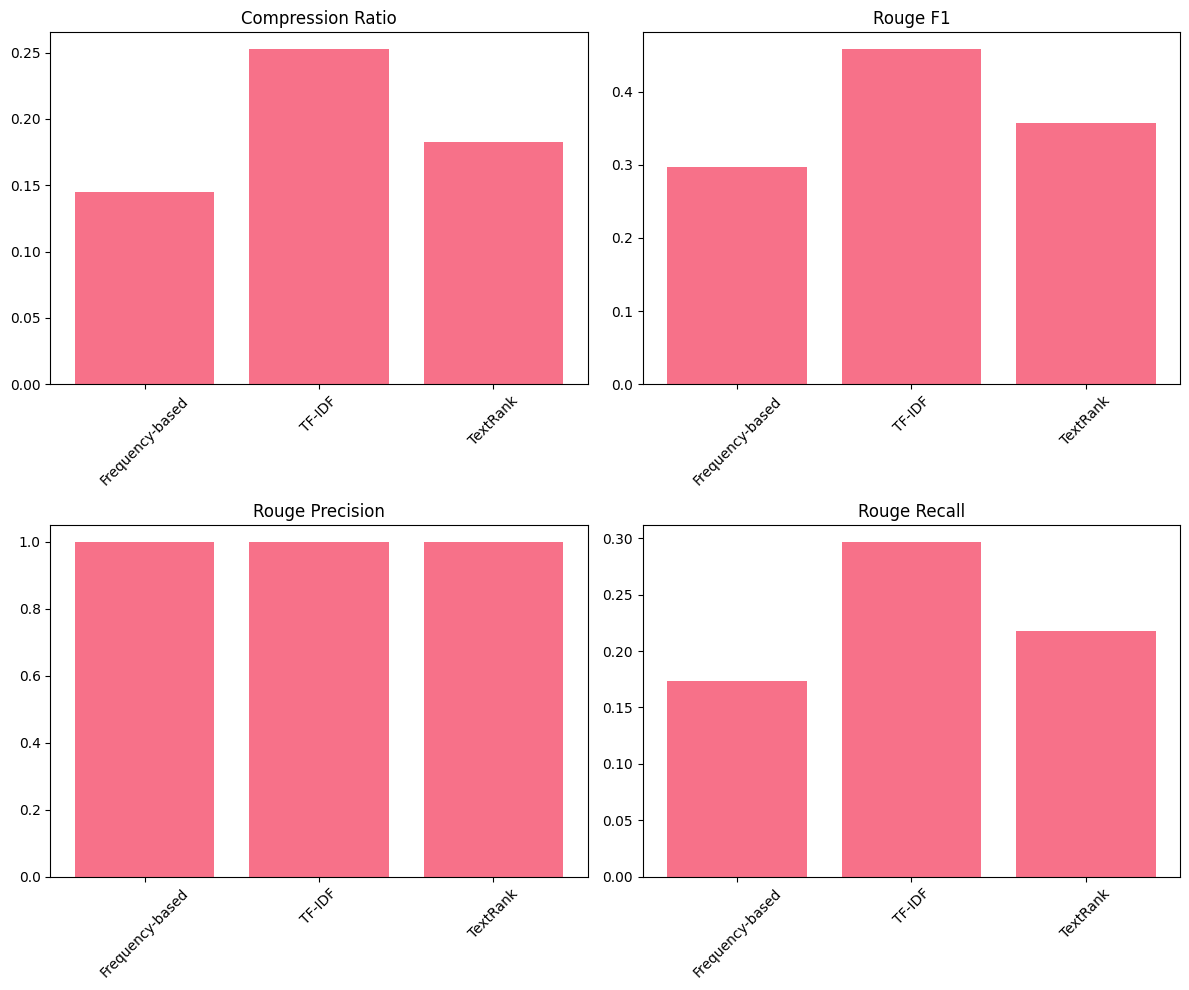

In [9]:
def calculate_rouge_simple(reference, candidate):
    """Simple ROUGE-1 calculation (word overlap)"""
    ref_words = set(word_tokenize(reference.lower()))
    cand_words = set(word_tokenize(candidate.lower()))

    if len(cand_words) == 0:
        return {'precision': 0, 'recall': 0, 'f1': 0}

    overlap = ref_words.intersection(cand_words)

    precision = len(overlap) / len(cand_words)
    recall = len(overlap) / len(ref_words) if len(ref_words) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

def evaluate_summary_quality(original_text, summary):
    """Evaluate summary quality with multiple metrics"""
    # Basic metrics
    original_words = len(word_tokenize(original_text))
    summary_words = len(word_tokenize(summary))
    compression_ratio = summary_words / original_words

    # Content preservation (overlap with original)
    rouge_scores = calculate_rouge_simple(original_text, summary)

    # Readability (sentence structure)
    summary_sentences = sent_tokenize(summary)
    avg_sentence_length = np.mean([len(word_tokenize(s)) for s in summary_sentences])

    return {
        'compression_ratio': compression_ratio,
        'rouge_precision': rouge_scores['precision'],
        'rouge_recall': rouge_scores['recall'],
        'rouge_f1': rouge_scores['f1'],
        'avg_sentence_length': avg_sentence_length,
        'num_sentences': len(summary_sentences)
    }

# Evaluate all summarization methods
print("Summarization Quality Evaluation:")
print("=" * 70)
print(f"{'Method':<15} {'Compression':<12} {'ROUGE-F1':<10} {'Precision':<10} {'Recall':<10}")
print("-" * 70)

evaluation_results = {}
for method, result in comparison_results.items():
    evaluation = evaluate_summary_quality(test_article, result['summary'])
    evaluation_results[method] = evaluation

    print(f"{method:<15} {evaluation['compression_ratio']:<12.2f} "
          f"{evaluation['rouge_f1']:<10.3f} {evaluation['rouge_precision']:<10.3f} "
          f"{evaluation['rouge_recall']:<10.3f}")

# Visualization
methods = list(evaluation_results.keys())
metrics = ['compression_ratio', 'rouge_f1', 'rouge_precision', 'rouge_recall']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, metric in enumerate(metrics):
    values = [evaluation_results[method][metric] for method in methods]
    axes[i].bar(methods, values)
    axes[i].set_title(f'{metric.replace("_", " ").title()}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Real-World Applications

In [10]:
# Application 1: News Article Summarization
def news_summarization_pipeline(articles, method='textrank'):
    """Process multiple news articles for summarization"""
    summaries = []

    for i, article in enumerate(articles):
        if method == 'frequency':
            result = frequency_based_summarization(article, num_sentences=2)
        elif method == 'tfidf':
            result = tfidf_based_summarization(article, num_sentences=2)
        elif method == 'textrank':
            result = textrank_summarization(article, num_sentences=2)
        else:
            result = {'summary': 'Unknown method'}

        summaries.append({
            'article_id': i,
            'original_length': len(article.split()),
            'summary': result['summary'],
            'summary_length': len(result['summary'].split())
        })

    return summaries

# Application 2: Document Clustering with Summaries
def summarize_document_clusters(documents):
    """Summarize documents and group by similarity"""
    summaries = []

    for doc in documents:
        summary_result = textrank_summarization(doc, num_sentences=1)
        summaries.append(summary_result['summary'])

    # Calculate similarity between summaries
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(summaries)
    similarity_matrix = cosine_similarity(tfidf_matrix)

    return summaries, similarity_matrix

# Application 3: Meeting Notes Summarization
def meeting_notes_summarization(meeting_text):
    """Specialized summarization for meeting notes"""
    # Extract action items and key decisions
    sentences = sent_tokenize(meeting_text)

    action_keywords = ['action', 'todo', 'follow up', 'next steps', 'assign', 'responsible']
    decision_keywords = ['decided', 'agreed', 'concluded', 'resolution', 'vote']

    action_items = []
    decisions = []
    other_important = []

    for sentence in sentences:
        sentence_lower = sentence.lower()

        if any(keyword in sentence_lower for keyword in action_keywords):
            action_items.append(sentence)
        elif any(keyword in sentence_lower for keyword in decision_keywords):
            decisions.append(sentence)
        else:
            # Use TF-IDF to score remaining sentences
            other_important.append(sentence)

    # Get general summary from remaining sentences
    if other_important:
        general_summary = tfidf_based_summarization(' '.join(other_important), num_sentences=2)
    else:
        general_summary = {'summary': 'No additional summary available'}

    return {
        'action_items': action_items[:3],  # Top 3 action items
        'decisions': decisions[:3],        # Top 3 decisions
        'general_summary': general_summary['summary']
    }

# Test applications
print("Real-World Applications:")
print("=" * 50)

# News summarization
news_articles = list(sample_articles.values())
news_summaries = news_summarization_pipeline(news_articles, method='textrank')

print("1. News Article Summaries:")
for summary in news_summaries:
    compression = summary['summary_length'] / summary['original_length']
    print(f"   Article {summary['article_id']}: {compression:.2f} compression")
    print(f"   Summary: {summary['summary'][:100]}...")

# Meeting notes example
meeting_text = """
The team discussed the quarterly goals and performance metrics. We decided to increase
the marketing budget by 20% for the next quarter. John will follow up with the design
team about the new product mockups. The action item for Sarah is to coordinate with
the sales team on lead generation strategies. We agreed that the current project
timeline needs to be extended by two weeks. The team concluded that remote work
policies should remain flexible. Next steps include scheduling client meetings
and preparing quarterly reports.
"""

meeting_summary = meeting_notes_summarization(meeting_text)

print("\n2. Meeting Notes Summary:")
print(f"   Action Items: {len(meeting_summary['action_items'])}")
for action in meeting_summary['action_items']:
    print(f"     - {action}")
print(f"   Decisions: {len(meeting_summary['decisions'])}")
for decision in meeting_summary['decisions']:
    print(f"     - {decision}")
print(f"   General Summary: {meeting_summary['general_summary']}")

Real-World Applications:
1. News Article Summaries:
   Article 0: 0.19 compression
   Summary: Machine learning algorithms 
    are now capable of performing tasks that were once thought to be ex...
   Article 1: 0.17 compression
   Summary: Climate change represents one of the most pressing challenges of our time. Many countries 
    have ...

2. Meeting Notes Summary:
   Action Items: 3
     - John will follow up with the design 
team about the new product mockups.
     - The action item for Sarah is to coordinate with 
the sales team on lead generation strategies.
     - Next steps include scheduling client meetings 
and preparing quarterly reports.
   Decisions: 3
     - We decided to increase 
the marketing budget by 20% for the next quarter.
     - We agreed that the current project 
timeline needs to be extended by two weeks.
     - The team concluded that remote work 
policies should remain flexible.
   General Summary: The team discussed the quarterly goals and performance met

## Exercises

1. **Multi-Document Summarization**: Combine multiple related documents into one summary
2. **Query-Focused Summarization**: Create summaries focused on specific questions or topics
3. **Timeline Summarization**: Summarize events in chronological order
4. **Sentiment-Aware Summarization**: Include sentiment information in summaries

## Key Takeaways

- **Extractive vs Abstractive**: Extractive selects existing sentences, abstractive generates new text
- **Multiple approaches**: Frequency-based, TF-IDF, TextRank, and transformer models each have strengths
- **Quality vs Speed**: Transformer models provide better quality but are slower
- **Domain matters**: Different types of text may need different summarization approaches
- **Evaluation is challenging**: Automatic metrics don't always capture human perception of quality

## Best Practices

1. **Choose appropriate method**: Consider your quality requirements and computational constraints
2. **Preprocess carefully**: Clean text and handle special formatting
3. **Set reasonable length targets**: Too short loses information, too long defeats the purpose
4. **Evaluate on your domain**: Generic models may not work well for specialized text
5. **Consider user needs**: Different users may need different types of summaries

## Applications

- **News aggregation**: Create brief summaries of news articles
- **Document management**: Summarize long reports and documents
- **Email processing**: Generate brief summaries of email threads
- **Research assistance**: Summarize academic papers and research
- **Content curation**: Create digests of content for different audiences

## Next Steps

- Learn about multi-document summarization techniques
- Explore query-focused and topic-specific summarization
- Study evaluation metrics like ROUGE, BLEU, and METEOR
- Practice with domain-specific documents
- Experiment with fine-tuning transformer models

## Resources

- [TextRank Paper](https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf)
- [BART Model](https://huggingface.co/facebook/bart-large-cnn)
- [ROUGE Evaluation](https://aclanthology.org/W04-1013/)
- [Hugging Face Summarization](https://huggingface.co/models?pipeline_tag=summarization)
- [DUC/TAC Evaluation Campaigns](https://duc.nist.gov/)